In [1]:
import torch
from torch import nn
from torch.nn import functional as F

class Basicblock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(Basicblock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_planes, out_channels=planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=planes, out_channels=planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(planes),
        )

        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_planes, out_channels=planes, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm2d(planes)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        self.block1 = self._make_layer(block, 16, num_block[0], stride=1)
        self.block2 = self._make_layer(block, 32, num_block[1], stride=2)
        self.block3 = self._make_layer(block, 64, num_block[2], stride=2)
        # self.block4 = self._make_layer(block, 512, num_block[3], stride=2)

        self.outlayer = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_block, stride):
        layers = []
        for i in range(num_block):
            if i == 0:
                layers.append(block(self.in_planes, planes, stride))
            else:
                layers.append(block(planes, planes, 1))
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.conv1(x))
        x = self.block1(x)                       # [200, 64, 28, 28]
        x = self.block2(x)                       # [200, 128, 14, 14]
        x = self.block3(x)                       # [200, 256, 7, 7]
        # out = self.block4(out)
        x = F.avg_pool2d(x, 7)                   # [200, 256, 1, 1]
        x = x.view(x.size(0), -1)                # [200,256]
        out = self.outlayer(x)
        return out

net = ResNet(Basicblock, [1, 1, 1, 1], 10)

In [1]:
#download mnist and #
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import os
import cv2

EPOCH = 10  
BATCH_SIZE = 200
LR = 0.001  


train_data = torchvision.datasets.MNIST(
    root='./data/',  
    train=True,  
    transform=torchvision.transforms.ToTensor(),  
    download=True,  
)

train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True  
)

test_data = torchvision.datasets.MNIST(
    root='./data/',
    train=False
)

test_x = torch.unsqueeze(test_data.train_data, dim=1).type(torch.FloatTensor)/255
test_y = test_data.test_labels

D:\anaconda\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
D:\anaconda\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [3]:
import time

print_every_batch=50

optimizer = torch.optim.Adam(net.parameters(), lr=LR)

loss_func = nn.CrossEntropyLoss()  

list_lost=[]
list_accuracy=[]
list_epoch_time=[]

for epoch in range(EPOCH):
    epoch_start_time = time.time()
    for batch_id, (batch_x, batch_y) in enumerate(train_loader):  
        output = net(batch_x)  
        loss = loss_func(output, batch_y)  
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  

        
        if batch_id % print_every_batch == 0:
            test_output = net(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            list_lost.append(loss.data.numpy())
            list_accuracy.append(accuracy)
            
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print("Epoch %d of %d with %.2f s" % (epoch + 1, EPOCH, per_epoch_ptime))
    list_epoch_time.append(per_epoch_ptime)

Epoch:  0 | train loss: 2.3746 | test accuracy: 0.18
Epoch:  0 | train loss: 0.6309 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2469 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1719 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0799 | test accuracy: 0.98
Epoch:  0 | train loss: 0.1109 | test accuracy: 0.98
Epoch 1 of 10 with 55.07 s
Epoch:  1 | train loss: 0.1018 | test accuracy: 0.98
Epoch:  1 | train loss: 0.0683 | test accuracy: 0.99
Epoch:  1 | train loss: 0.0704 | test accuracy: 0.99
Epoch:  1 | train loss: 0.0512 | test accuracy: 0.99
Epoch:  1 | train loss: 0.0382 | test accuracy: 0.99
Epoch:  1 | train loss: 0.0348 | test accuracy: 0.99
Epoch 2 of 10 with 55.05 s
Epoch:  2 | train loss: 0.0434 | test accuracy: 0.99
Epoch:  2 | train loss: 0.0615 | test accuracy: 0.99
Epoch:  2 | train loss: 0.0254 | test accuracy: 0.99
Epoch:  2 | train loss: 0.0229 | test accuracy: 0.99
Epoch:  2 | train loss: 0.0380 | test accuracy: 0.99
Epoch:  2 | train loss: 0.0193 | test accurac

In [4]:
import numpy as np
lost_array=np.array(list_lost)
list_accuracy=np.array(list_accuracy)
list_epoch_time=np.array(list_epoch_time)

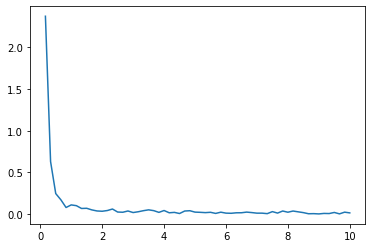

In [5]:
plt.plot(np.array(list(range(1,61)))/6,lost_array)

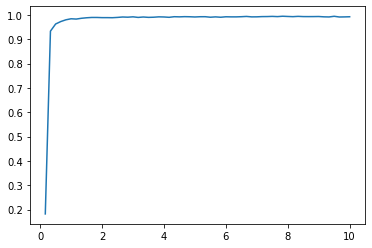

In [6]:
plt.plot(np.array(list(range(1,61)))/6,list_accuracy)

In [7]:
sum(list_epoch_time)/10

55.179085445404056

In [8]:
torch.save(net, "resnet.pth")  

In [9]:
model = torch.load("resnet.pth")
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (block1): Sequential(
    (0): Basicblock(
      (conv1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
  )
  (block2): Sequential(
    (0): Basicblock(
      (conv1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bia

In [10]:
test_output = model(test_x)
pred_y = torch.max(test_output, 1)[1].data.numpy()
accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

Epoch:  9 | train loss: 0.0045 | test accuracy: 0.99


In [11]:
pred_y=pred_y.tolist()
test_y=test_y.tolist()

In [12]:
for i in range(1000):
    
    if pred_y[i]!=test_y[i]:
        print(i)

115
340
445
582
674
726
947


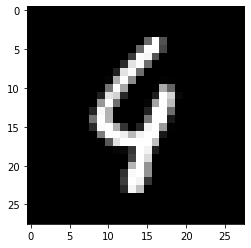

In [13]:
plt.imshow(test_x[115,0,:,:],cmap='gray')

In [16]:
pred_y[115]

9

In [17]:
test_y[115]

4

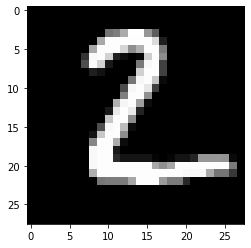

In [2]:
plt.imshow(test_x[1,0,:,:],cmap='gray')

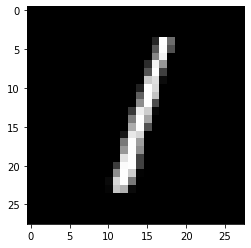

In [3]:
plt.imshow(test_x[2,0,:,:],cmap='gray')

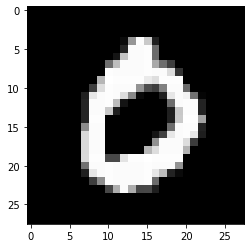

In [4]:
plt.imshow(test_x[3,0,:,:],cmap='gray')